## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Step 1: Compute the camera's calibration settings using chessboard images

###### Step 1a: Compute the checker point matches

In [16]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Starting...")
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #plt.imshow('img',img)
        #plt.imshow(img.squeeze())
        #print("drawing")
        #cv2.waitKey(500)

print("Done!")

Starting...
Done!


###### Step 1b: Test undistortion

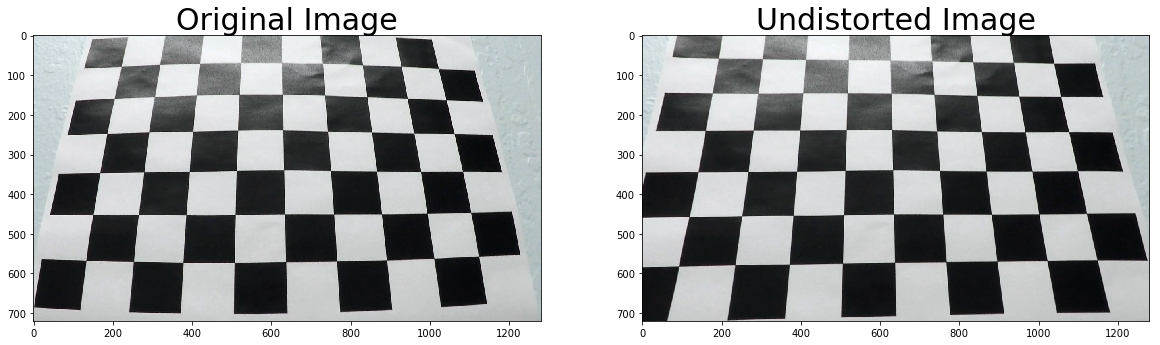

In [2]:
# Undistortion on an image
# Use cv2.calibrateCamera and cv2.undistort()

def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Undistort the test image
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst


# Import a distorted image
img = cv2.imread('../camera_cal/calibration3.jpg')
dst = cal_undistort(img, objpoints, imgpoints)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

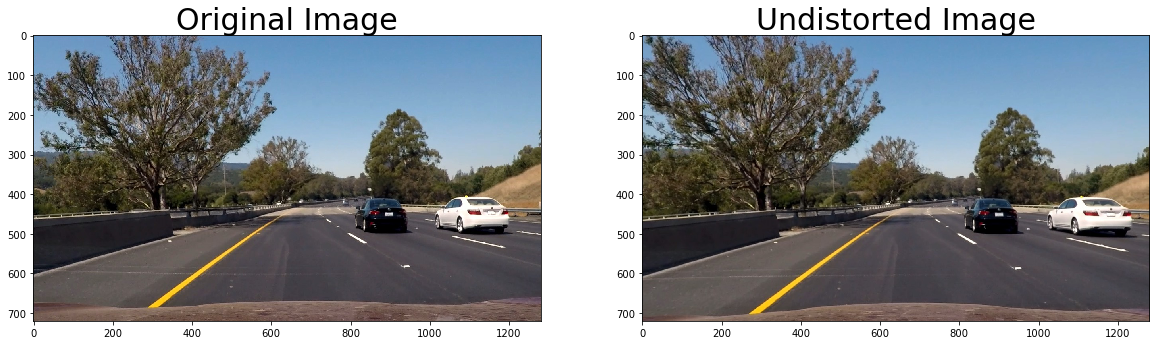

In [11]:
# Import a distorted image
img = mpimg.imread('../test_images/test6.jpg')
#img2 = img.copy()
dst = cal_undistort(img, objpoints, imgpoints)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

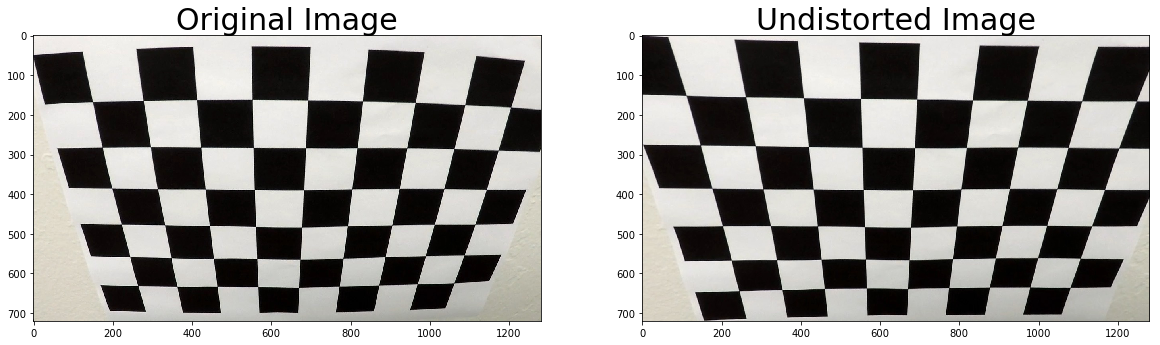

In [13]:
# Import a distorted image
img = mpimg.imread('../camera_cal/calibration2.jpg')
dst = cal_undistort(img, objpoints, imgpoints)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Step 2: 

In [ ]:
# First Detect Lane Lines Using Masking, Color, And Gradiant Thresholding

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if(orient=='x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # sobelx
    elif(orient=='y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # sobely

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    #    is > thresh_min and < thresh_max
    thresh_min = thresh_min
    thresh_max = thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray')
    
    # 6) Return this mask as your binary_output image
    #    return binary_output
    return sbinary

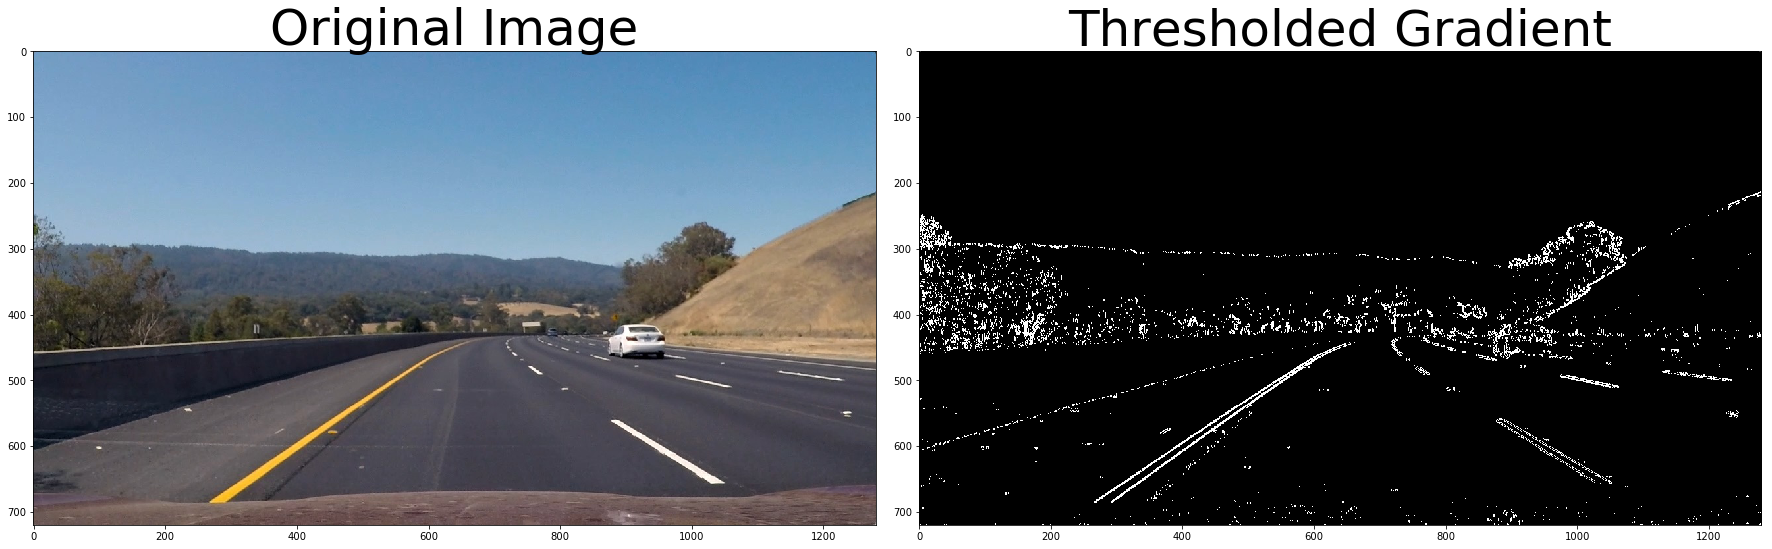

In [6]:
# Read in an image and grayscale it
image = mpimg.imread('../test_images/test3.jpg')

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [ ]:
# Run the function
image = mpimg.imread('../test_images/test3.jpg')
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [ ]:
# Run the function
image = mpimg.imread('../test_images/test3.jpg')
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Experiment with combinations of these three thresholds

ksize = 3 # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
#gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
#grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary) 
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[ ( (gradx==1)&(grady==1) ) | 
#          ( (mag_binary==1)&(dir_binary==1) )
#        ] = 1
combined[ ( (gradx==1)&(grady==1) ) | 
          ( (mag_binary==1)&(dir_binary==1) )
        ] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Exploring Color Spaces

In [ ]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [ ]:
# Run the function
image = mpimg.imread('../test_images/test3.jpg')
hls_binary = hls_select(image, thresh=(200, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

In [ ]:
# Edit this function to create your own pipeline.
def pipeline2(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #return color_binary
    return combined_binary

In [ ]:
image = mpimg.imread('../test_images/test5.jpg')
result = pipeline2(image, s_thresh=(170, 255), sx_thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

#ax2.imshow(result)
ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Make A Perspective Transform To Get A Birds Eye View

In [20]:
# leftupperpoint = [520,470]
# leftlowerpoint = [170,700]
# rightupperpoint = [770,470]
# rightlowerpoint = [1200,700]
leftupperpoint = [568,470]
rightupperpoint = [717,470]
leftlowerpoint = [260,680]
rightlowerpoint = [1043,680]

In [21]:
def plot(image):
    # leftupperpoint = (520,470)
    # leftlowerpoint = (170,700)
    # rightupperpoint = (770,470)
    # rightlowerpoint = (1200,700)
#     cv2.circle(image, tuple(leftupperpoint), 2, 100, -1)
#     cv2.circle(image, tuple(leftlowerpoint), 2, 100, -1)
#     cv2.circle(image, tuple(rightupperpoint), 2, 100, -1)
#     cv2.circle(image, tuple(rightlowerpoint), 2, 100, -1)
    pts = np.array([leftupperpoint,rightupperpoint,rightlowerpoint,leftlowerpoint], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(image,[pts],True,(0,255,255))
    return image

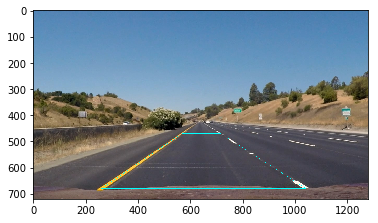

In [22]:
image = mpimg.imread('../test_images/straight_lines1.jpg')
#image = mpimg.imread('../test_images/straight_lines2.jpg')
#image = mpimg.imread('../test_images/test1.jpg')
#image = mpimg.imread('../test_images/test4.jpg')
#image = mpimg.imread('../test_images/test5.jpg')
#image = mpimg.imread('../test_images/test6.jpg')
result = plot(image)
plt.imshow(result.squeeze())

In [23]:
# Compute and apply perpective transform

def warper(img):    
    src = np.float32([[leftupperpoint],[leftlowerpoint],[rightupperpoint],[rightlowerpoint]])
    #dst = np.float32([[170,400],leftlowerpoint,[1200,400],rightlowerpoint])
    #dst = np.float32([[170,0],leftlowerpoint,[1200,0],rightlowerpoint])
    #dst = np.float32([[300,0],leftlowerpoint,[1000,0],rightlowerpoint])
    #dst = np.float32([[260,0],leftlowerpoint,[1040,0],rightlowerpoint])
    dst = np.float32([[200,0],[200,680],[1000,0],[1000,680]])
    #dst = np.float32([[400,0],[400,680],[800,0],[800,680]])
    img_size = (img.shape[1], img.shape[0])    
    M = cv2.getPerspectiveTransform(src, dst)
    #warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

In [25]:
image = mpimg.imread('../test_images/straight_lines1.jpg')
#image = mpimg.imread('../test_images/test3.jpg')
image = plot(image)
#plt.imshow(result.squeeze())
result = warper(image)
#plt.imshow(image.squeeze())
#plt.imshow(result.squeeze())

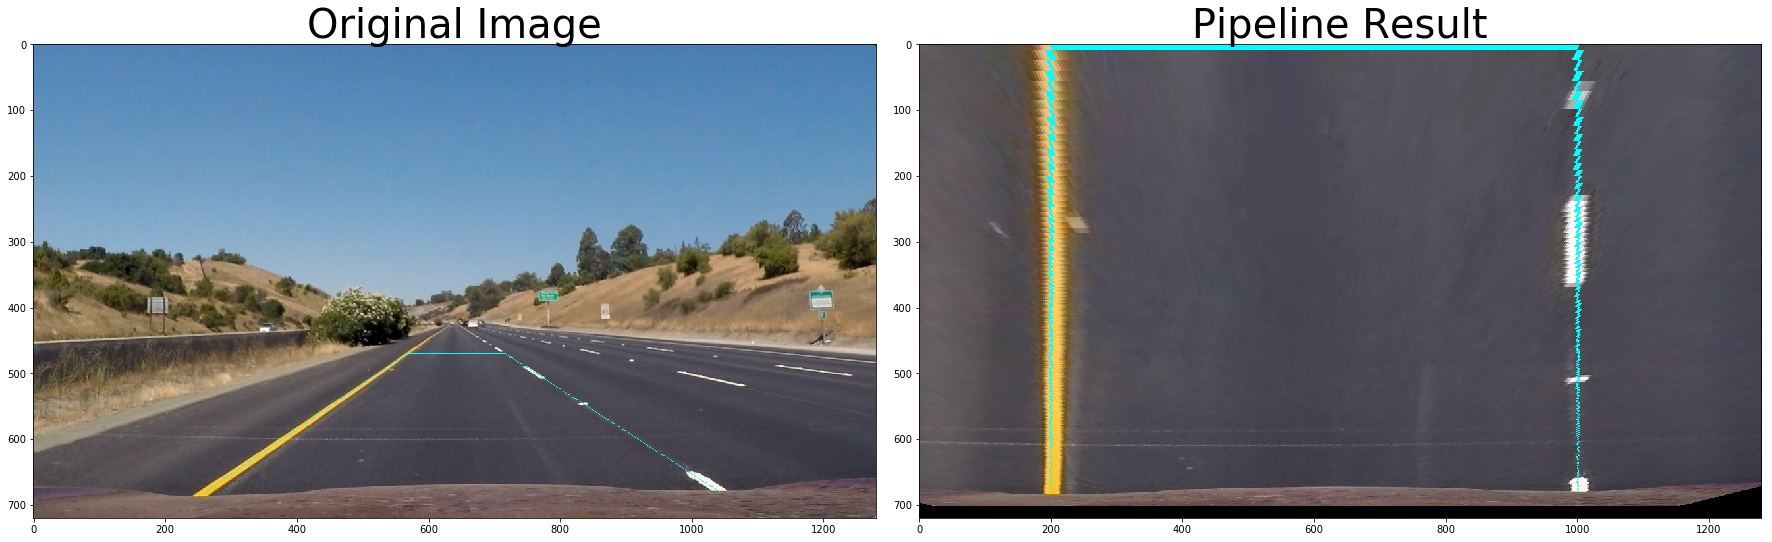

In [26]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

#ax2.imshow(result)
ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# # Example 1:
# # Define a function that takes an image, number of x and y points, 
# # camera matrix and distortion coefficients
# def corners_unwarp(img, nx, ny, mtx, dist):
#     # Use the OpenCV undistort() function to remove distortion
#     undist = cv2.undistort(img, mtx, dist, None, mtx)
#     # Convert undistorted image to grayscale
#     gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
#     # Search for corners in the grayscaled image
#     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

#     if ret == True:
#         # If we found corners, draw them! (just for fun)
#         cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
#         # Choose offset from image corners to plot detected corners
#         # This should be chosen to present the result at the proper aspect ratio
#         # My choice of 100 pixels is not exact, but close enough for our purpose here
#         offset = 100 # offset for dst points
#         # Grab the image shape
#         img_size = (gray.shape[1], gray.shape[0])

#         # For source points I'm grabbing the outer four detected corners
#         src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
#         # For destination points, I'm arbitrarily choosing some points to be
#         # a nice fit for displaying our warped result 
#         # again, not exact, but close enough for our purposes
#         dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
#                                      [img_size[0]-offset, img_size[1]-offset], 
#                                      [offset, img_size[1]-offset]])
#         # Given src and dst points, calculate the perspective transform matrix
#         M = cv2.getPerspectiveTransform(src, dst)
#         # Warp the image using OpenCV warpPerspective()
#         warped = cv2.warpPerspective(undist, M, img_size)

#     # Return the resulting image and matrix
#     return warped, M

In [ ]:
def pipeline_v1(img):
    # undistort the image
    img = cal_undistort(img, objpoints, imgpoints)
    

In [ ]:
# Detect Lanes Again, Determine Shape And Position, And Calculate Curvature